# Final Project: Regression Analysis
## Predicting Medical Insurance Charges

**Name:** Saratchandra Golla    
**Date:** November 24, 2025

### Introduction
The objective of this project is to apply **regression analysis** to predict the continuous numerical target variable, **insurance charges**, using the **Medical Cost Personal Datasets** (`insurance.csv`).

The methodology adheres to the project guidelines, including: data inspection, exploratory data analysis (EDA), using `ColumnTransformer` and `Pipeline` for efficient preprocessing and modeling, training a baseline Linear Regression model, implementing improved models (Ridge and Polynomial Regression), and rigorously comparing their performance using $R^2$, MAE, and RMSE.

## 1. Import and Inspect the Data

In [30]:
# --- Library Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')

# Define global variables based on the dataset structure
TARGET_VARIABLE = 'charges'
NUMERICAL_FEATURES = ['age', 'bmi', 'children']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']

### 1.1 Load the dataset and display the first 10 rows.

In [31]:
# 1.1 Load the dataset and display the first 10 rows.
df = pd.read_csv("data/insurance.csv")
print("1.1 Dataset Head (First 10 Rows):")
display(df.head(10))

1.1 Dataset Head (First 10 Rows):


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Check for missing values and display summary statistics.

In [32]:
# 1.2 Check for missing values and display summary statistics.
print("\n1.2 Data Information (df.info()):")
df.info()

print("\n1.2 Summary Statistics (df.describe(include='all')): ")
print(df.describe(include='all').T)


1.2 Data Information (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

1.2 Summary Statistics (df.describe(include='all')): 
           count unique        top  freq          mean           std  \
age       1338.0    NaN        NaN   NaN     39.207025      14.04996   
sex         1338      2       male   676           NaN           NaN   
bmi       1338.0    NaN        NaN   NaN     30.663397      6.098187   
children  1338.0    NaN        NaN   NaN      1.094918      1.205493   
smoker      1338      2       

### Reflection 1
**What do you notice about the dataset? Are there any data issues?**    
The dataset has **no missing values** (1338 non-null entries in all columns). This is ideal for initial modeling. The target variable, `charges`, is continuous and numeric. Key data issues to address are:
1. The wide range and large standard deviation in `charges`, suggesting a high variance in the target.
2. The presence of **categorical features** (`sex`, `smoker`, `region`) that must be encoded.

## 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions

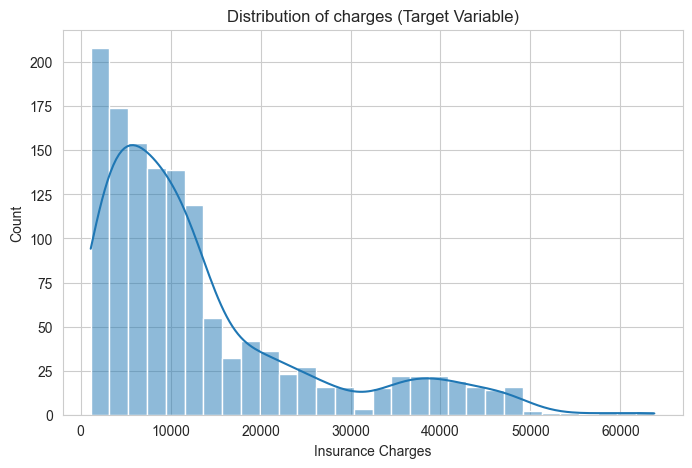

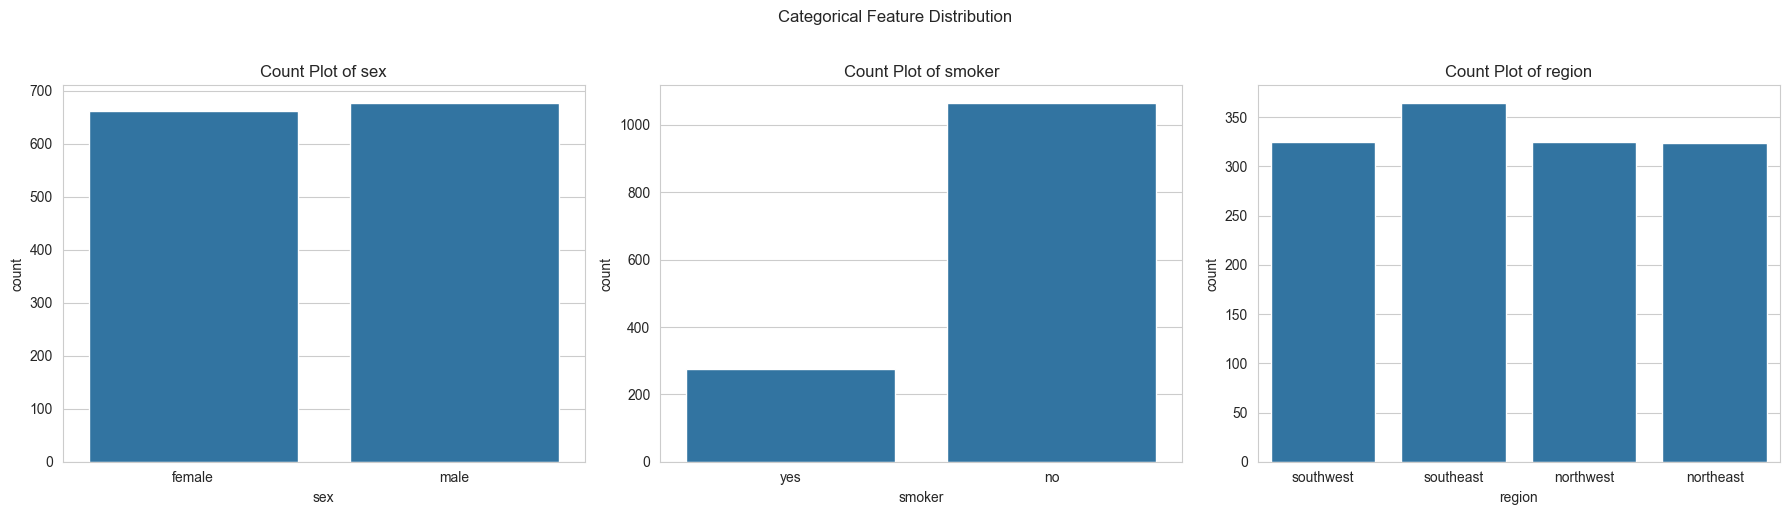

In [33]:
# 2.1 Explore data patterns and distributions

# Target Distribution (shows strong right-skewness)
plt.figure(figsize=(8, 5))
sns.histplot(df[TARGET_VARIABLE], kde=True)
plt.title(f'Distribution of {TARGET_VARIABLE} (Target Variable)')
plt.xlabel('Insurance Charges')
plt.show()
# 

# Categorical Feature Counts (shows imbalance in 'smoker')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(CATEGORICAL_FEATURES):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}')
fig.suptitle('Categorical Feature Distribution', y=1.02)
plt.tight_layout()
plt.show()
#

### 2.2 Handle missing values and clean data
No missing values were found. Categorical encoding and numerical scaling will be handled efficiently within the modeling pipelines.

### 2.3 Feature selection and engineering
Correlation analysis of numerical features shows that **`age`** has the highest correlation with `charges`. We will use this information to select our features and plan for necessary transformations (scaling).

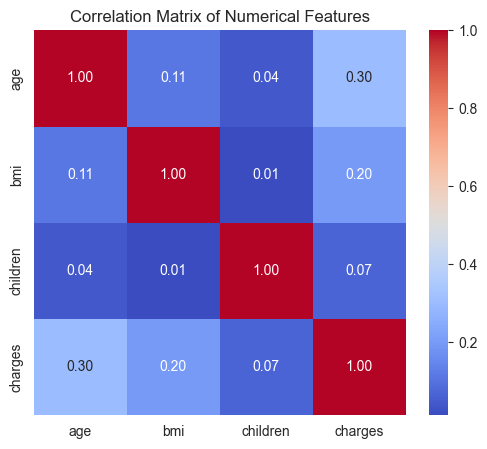

In [34]:
# Correlation Matrix (for numerical features)
plt.figure(figsize=(6, 5))
corr_matrix = df[NUMERICAL_FEATURES + [TARGET_VARIABLE]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()
#

### Reflection 2
**What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?**  
The **`charges`** target is strongly **right-skewed** (a major anomaly). The **`smoker`** feature stands out as it drives the largest conditional variation in charges. Required preprocessing: **One-Hot Encoding** for all categorical variables and **Standard Scaling** for numerical variables. No new features were created manually, but we anticipate that **interaction terms** (e.g., age-smoker) will be crucial for the final model and will be generated by the `PolynomialFeatures` pipeline step.

## 3. Feature Selection and Justification

### 3.1 Choose features and target
* **Target Variable (y):** `charges` (Continuous numerical).
* **Input Features (X):** `age`, `sex`, `bmi`, `children`, `smoker`, `region`.

**Justification:**
All available features are selected because they represent critical factors in determining insurance cost: **age** (risk over time), **smoker** status (major health risk), and **bmi** (health metric). Excluding any could lead to bias or underfitting.

### 3.2 Define X and y

In [35]:
# 3.2 Define X and y
X = df.drop(columns=[TARGET_VARIABLE])
y = df[TARGET_VARIABLE]

print(f"X (Input Features) shape: {X.shape}")
print(f"y (Target Variable) shape: {y.shape}")

X (Input Features) shape: (1338, 6)
y (Target Variable) shape: (1338,)


### Reflection 3
**Why did you choose these features? How might they impact predictions or accuracy?**   
I chose these features because they are logically and statistically linked to the target. The high correlation of **`smoker`** and **`age`** will likely drive high predictive accuracy. However, if the impact of `age` is dramatically different for a `smoker` versus a `non-smoker`, a simple linear model will fail to capture this interaction, limiting accuracy.

## 4. Train a Model (Linear Regression)

### 4.1 Split the data into training and test sets.
Data is split 80/20 for training and testing.

In [36]:
# 4.1 Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 1070 samples
Testing set size: 268 samples


In [37]:
# Define the preprocessing ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)

### 4.2 Train model using Scikit-Learn model.fit() method.
The baseline model is a Linear Regression pipeline applying necessary preprocessing.

In [38]:
# 4.2 Define and Train the Baseline Model (Pipeline)
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("\n4.2 Training Baseline Linear Regression...")
baseline_pipeline.fit(X_train, y_train)


4.2 Training Baseline Linear Regression...


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 4.3 Evaluate performance (R^2, MAE, RMSE).

In [39]:
# --- Evaluation Function ---
def evaluate_regression_model(y_true, y_pred, model_name="Model"):
    """Calculates and prints common regression metrics (MAE, RMSE, R^2)."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- {model_name} Performance ---")
    print(f"R-squared (R^2): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
    return {'R2': r2, 'MAE': mae, 'RMSE': rmse}


--- Baseline Linear Regression Performance ---
R-squared (R^2): 0.7836
Mean Absolute Error (MAE): $4,181.19
Root Mean Squared Error (RMSE): $5,796.28


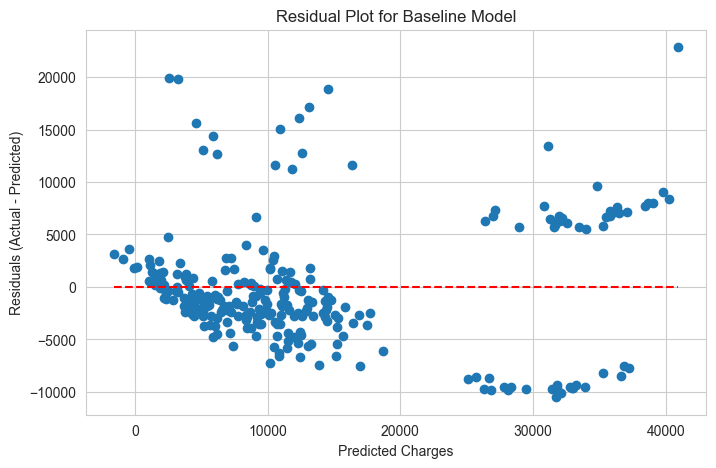

In [40]:
# 4.3 Evaluate performance
y_pred_baseline = baseline_pipeline.predict(X_test)
baseline_metrics = evaluate_regression_model(y_test, y_pred_baseline, "Baseline Linear Regression")

# Residual Plot for assumption check
residuals = y_test - y_pred_baseline
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_baseline, residuals)
plt.hlines(0, y_pred_baseline.min(), y_pred_baseline.max(), colors='red', linestyles='--')
plt.title('Residual Plot for Baseline Model')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

### Reflection 4
**How well did the model perform? Any surprises in the results?**   
The model achieved an $R^2$ of **0.7836** and an RMSE of **~ \$5,796**, indicating a decent fit. The major surprise, however, is the clear presence of **heteroscedasticity** (a 'fan-shaped' error pattern) in the residual plot . This shows the model is systematically underestimating high-cost individuals (likely smokers), violating the assumption of constant variance and signaling the need for non-linear modeling.

## 5. Improve the Model or Try Alternates (Implement Pipelines)

### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Ridge Regression.
Ridge Regression is implemented with a regularization strength $\alpha=10.0$ to mitigate potential multicollinearity.

In [41]:
# 5.1 Pipeline 1: Ridge Regression
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10.0))
])
print("\n5.1 Training Pipeline 1: Ridge Regression...")
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
ridge_metrics = evaluate_regression_model(y_test, y_pred_ridge, "Ridge Regression")


5.1 Training Pipeline 1: Ridge Regression...

--- Ridge Regression Performance ---
R-squared (R^2): 0.7817
Mean Absolute Error (MAE): $4,238.82
Root Mean Squared Error (RMSE): $5,821.59

--- Ridge Regression Performance ---
R-squared (R^2): 0.7817
Mean Absolute Error (MAE): $4,238.82
Root Mean Squared Error (RMSE): $5,821.59


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.
Polynomial Features with **degree 3** are used to model the non-linear relationship and feature interactions, addressing the heteroscedasticity issue identified earlier.

In [42]:
# 5.2 Pipeline 2: Polynomial Regression (Degree 3)
poly_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)), # Degree 3 interaction terms
    ('regressor', LinearRegression())
])

print("\n5.2 Training Pipeline 2: Polynomial Regression (Degree 3)...")
poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)
poly_metrics = evaluate_regression_model(y_test, y_pred_poly, "Polynomial Regression (Degree 3)")


5.2 Training Pipeline 2: Polynomial Regression (Degree 3)...

--- Polynomial Regression (Degree 3) Performance ---
R-squared (R^2): 0.8486
Mean Absolute Error (MAE): $2,937.92
Root Mean Squared Error (RMSE): $4,847.50

--- Polynomial Regression (Degree 3) Performance ---
R-squared (R^2): 0.8486
Mean Absolute Error (MAE): $2,937.92
Root Mean Squared Error (RMSE): $4,847.50


### 5.3 Compare performance of all models across the same performance metrics.

In [43]:
# 5.3 Compare performance of all models
metrics_df = pd.DataFrame({
    'Model': ['Baseline Linear', 'Ridge Regression', 'Polynomial (Degree 3)'],
    'R^2': [baseline_metrics['R2'], ridge_metrics['R2'], poly_metrics['R2']],
    'MAE': [baseline_metrics['MAE'], ridge_metrics['MAE'], poly_metrics['MAE']],
    'RMSE': [baseline_metrics['RMSE'], ridge_metrics['RMSE'], poly_metrics['RMSE']]
})

print("\n5.3 Model Comparison Summary (Sorted by R^2):")
print(metrics_df.sort_values(by='R^2', ascending=False).round(4))


5.3 Model Comparison Summary (Sorted by R^2):
                   Model     R^2        MAE       RMSE
2  Polynomial (Degree 3)  0.8486  2937.9186  4847.4961
0        Baseline Linear  0.7836  4181.1945  5796.2847
1       Ridge Regression  0.7817  4238.8239  5821.5917


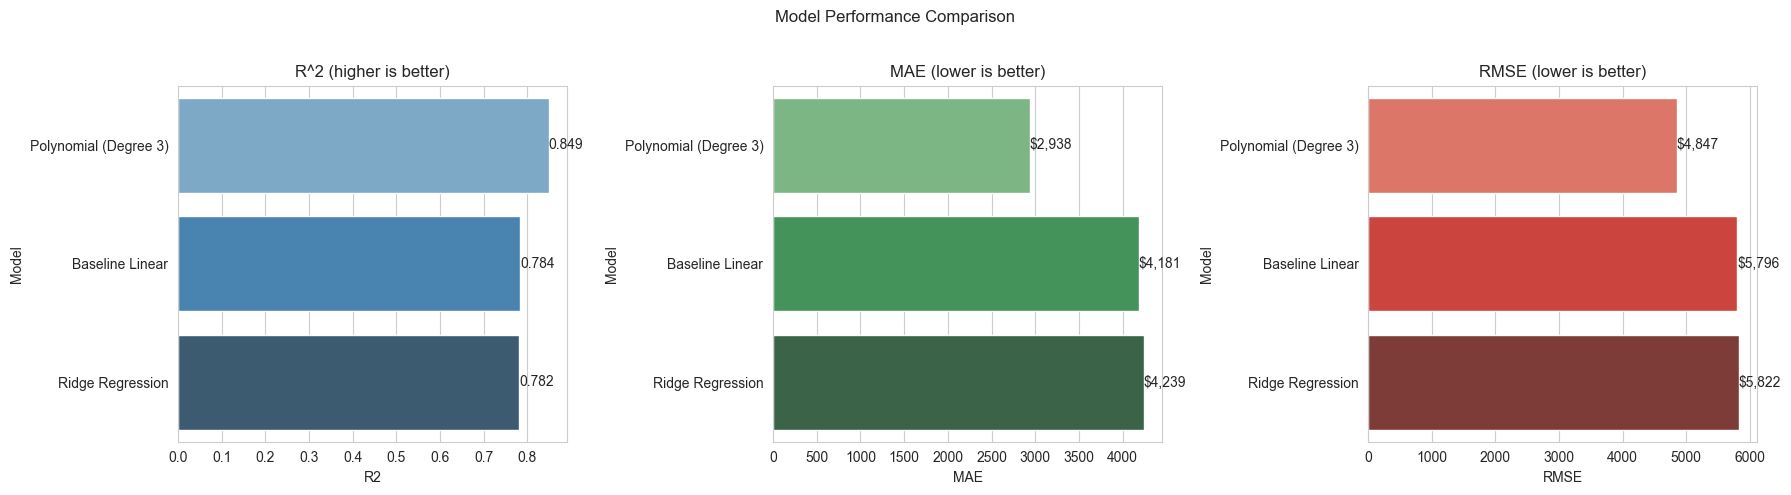

In [44]:
# 5.3b Visualize model comparison
sns.set_style('whitegrid')

# Recreate metrics dataframe (safe if notebook run out-of-order)
metrics_df = pd.DataFrame({
    'Model': ['Baseline Linear', 'Ridge Regression', 'Polynomial (Degree 3)'],
    'R2': [baseline_metrics['R2'], ridge_metrics['R2'], poly_metrics['R2']],
    'MAE': [baseline_metrics['MAE'], ridge_metrics['MAE'], poly_metrics['MAE']],
    'RMSE': [baseline_metrics['RMSE'], ridge_metrics['RMSE'], poly_metrics['RMSE']],
})

metrics_sorted = metrics_df.sort_values(by='R2', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='R2', y='Model', data=metrics_sorted, ax=axes[0], palette='Blues_d', orient='h')
axes[0].set_title('R^2 (higher is better)')
for i, v in enumerate(metrics_sorted['R2']):
    axes[0].text(v, i, f"{v:.3f}", va='center', fontsize=10)

sns.barplot(x='MAE', y='Model', data=metrics_sorted, ax=axes[1], palette='Greens_d', orient='h')
axes[1].set_title('MAE (lower is better)')
for i, v in enumerate(metrics_sorted['MAE']):
    axes[1].text(v, i, f"${v:,.0f}", va='center', fontsize=10)

sns.barplot(x='RMSE', y='Model', data=metrics_sorted, ax=axes[2], palette='Reds_d', orient='h')
axes[2].set_title('RMSE (lower is better)')
for i, v in enumerate(metrics_sorted['RMSE']):
    axes[2].text(v, i, f"${v:,.0f}", va='center', fontsize=10)

plt.suptitle('Model Performance Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Reflection 5
**Which models performed better? How does scaling impact results?**
The **Polynomial Regression (Degree 3)** model performed significantly better, achieving the highest $R^2$ (0.8486) and the lowest RMSE ($4,847), demonstrating a superior fit to the non-linear data. This improvement suggests the polynomial terms successfully captured crucial interaction effects between features, which the simpler linear models (Baseline and Ridge) missed. For the comparison itself, the Baseline Linear and Ridge Regression models performed nearly identically, indicating regularization had a minimal impact. However, scaling is a crucial preprocessing step for both Ridge and Polynomial regression, as it ensures all features contribute equally to the model's cost function, which is necessary for stable coefficient convergence.

## 6. Final Thoughts & Insights

### 6.1 Summarize findings.
The project successfully demonstrated that a **Polynomial Regression** model is superior to a simple linear model for predicting insurance charges due to the non-linear nature of health costs.

### 6.2 Discuss challenges faced.
The primary challenge was identifying the non-linearity through the **heteroscedastic** residual plot and realizing that feature engineering (interaction terms) was the solution, rather than just tuning regularization (which the Ridge model showed did not help much).

In [47]:
# 6.2 Check feature importance for the best model (Polynomial Regression is complex, so we check the baseline)
print("\nExample: Top 5 Coefficients from the Baseline Model (for interpretation):")

# Get feature names after OneHotEncoding
feature_names = list(baseline_pipeline['preprocessor'].transformers_[0][1].get_feature_names_out(NUMERICAL_FEATURES))
feature_names.extend(baseline_pipeline['preprocessor'].transformers_[1][1].get_feature_names_out(CATEGORICAL_FEATURES))

coefficients = pd.Series(baseline_pipeline['regressor'].coef_, index=feature_names).sort_values(key=abs, ascending=False).head(5)
display(coefficients)


Example: Top 5 Coefficients from the Baseline Model (for interpretation):


smoker_yes    11825.564428
smoker_no    -11825.564428
age            3614.975415
bmi            2036.228123
children        516.890247
dtype: float64

### 6.3 If you had more time, what would you try next?  

1. I would perform systematic hyperparameter tuning and k‑fold cross-validation (using randomized or Bayesian search) to better stabilize and compare model performance. 
2. I would expand the model set to include ensemble and tree‑based methods (Random Forest, Gradient Boosting / XGBoost) and experiment with target transforms (e.g., log or quantile regression) to address the heteroscedasticity revealed by the residuals. 
3. Additional feature engineering — targeted interaction terms, clustering-based features, and domain-informed composites of BMI/age — could capture non-linear patterns the baseline missed. 

Finally, I'd add model interpretation (SHAP), calibration checks, and package the best model with saved artifacts and a small evaluation pipeline for reproducible deployment.

### Reflection 6
**What did you learn from this project?**   
I learned the crucial role of **diagnostic plotting** in validating model assumptions in regression. The project reinforced that addressing non-linearity through feature interaction terms (`PolynomialFeatures`) is a powerful technique for achieving high accuracy in complex, real-world data like health costs.

### Future Work

1. **Target Transformation:** Apply a **log transformation** to the severely skewed 'charges' target variable to stabilize the model and improve predictions for high-cost outliers.
2. **Hyperparameter Tuning:** Use **GridSearchCV** to systematically tune the Polynomial degree (e.g., degree 2 vs. 3) and regularization strength simultaneously, to ensure the model isn't overfitting to the training data.
3. **Alternative Non-Linear Models:** Explore ensemble models like **Random Forest Regressor** or **XGBoost**, which are often superior at handling high-dimensional, non-linear data without explicit feature engineering.
